# Подготовка к работе: импорт библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
events = pd.read_csv('data/events.csv')
events.head()

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1
2,0,584,4,2
3,0,3390,3,3
4,0,2885,4,4


In [3]:
item_features = pd.read_csv('data/item_features.csv')
item_features.head()

,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17
0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:
user_features = pd.read_csv('data/user_features.csv')
user_features.head()

,user_id,gender,age
0,4855,F,1
1,4065,M,56
2,3331,M,25
3,5373,M,45
4,2032,M,25


In [5]:
submission_sample = pd.read_csv('data/submission_sample.csv')
submission_sample.head()

,user_id,item_id
0,0,0 1 2 3 4 5 6 7 8 9
1,1,0 1 2 3 4 5 6 7 8 9
2,2,0 1 2 3 4 5 6 7 8 9
3,3,0 1 2 3 4 5 6 7 8 9
4,4,0 1 2 3 4 5 6 7 8 9


## EDA

In [6]:
events[['rating', 'timestamp']].describe()

,rating,timestamp
count,894149.000000,894149.000000
mean,3.580947,194.684738
std,1.116696,218.812300
min,1.000000,0.000000
25%,3.000000,45.000000
50%,4.000000,119.000000
75%,4.000000,267.000000
max,5.000000,2312.000000


**Активность пользователя**

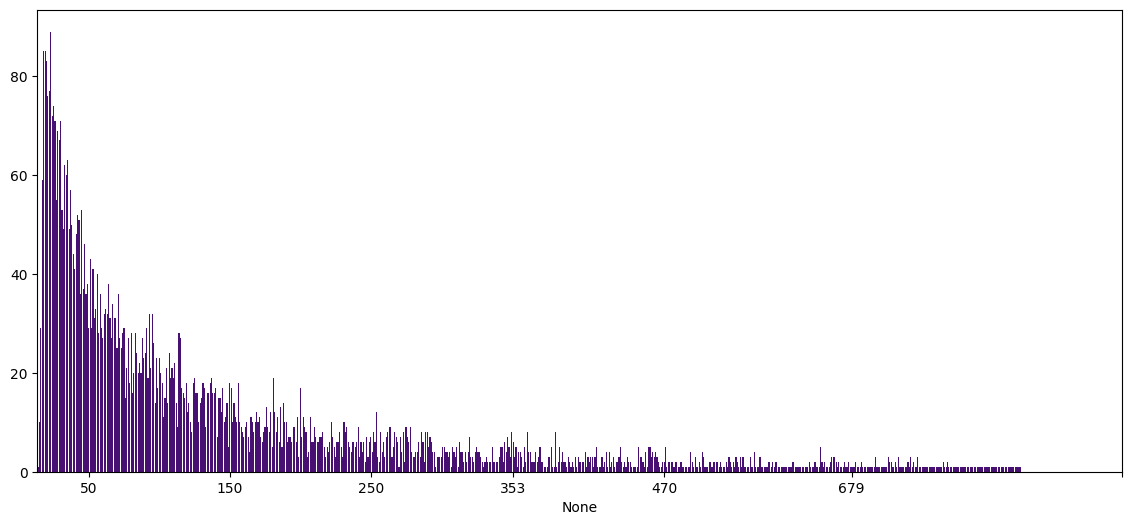

In [7]:
event_count_per_user = events.groupby('user_id').size().value_counts().sort_index()

plt.figure(figsize=(14, 6))
sns.barplot(x = event_count_per_user.index, y = event_count_per_user.values, color='indigo')

#plt.xticks(rotation=45)  # Rotate xticks for better readability
# Alternatively, to show only a subset of xticks
plt.xticks(event_count_per_user.index[22::100])
plt.show()

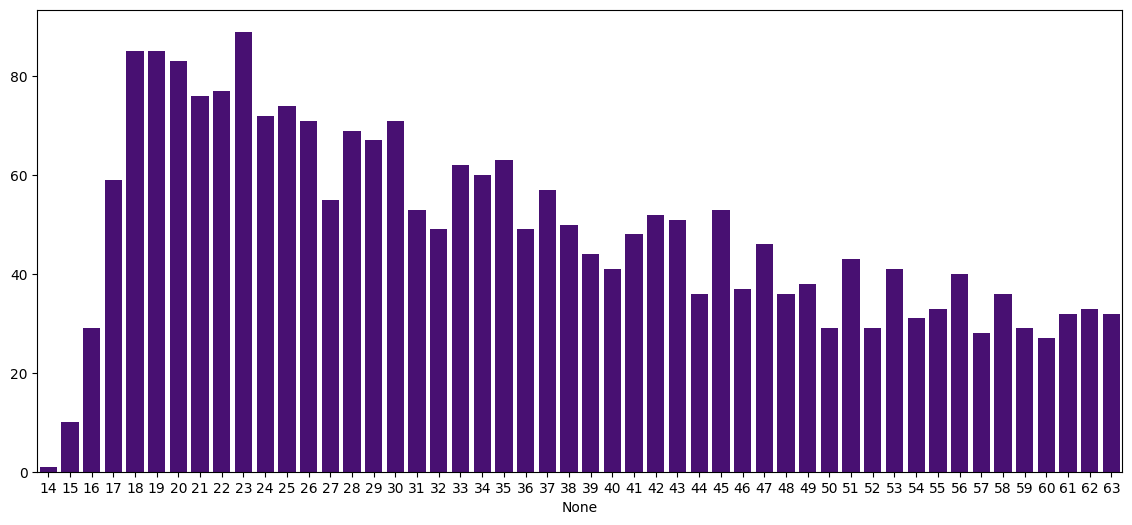

In [8]:
plt.figure(figsize=(14, 6))
sns.barplot(x = event_count_per_user.index[:50], y = event_count_per_user.values[:50], color='indigo')
plt.show()

In [9]:
#df_merged_user_features = events.join(user_features['gender'], on = 'user_id').join(user_features['age'], on = 'user_id')
#df_merged = df_merged_user_features.join(item_features[['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4','genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10',
#       'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17']], on = 'item_id')
#df_merged.head()

**Демография пользователя**

In [11]:
user_features.gender.value_counts()

gender
M    4331
F    1709
Name: count, dtype: int64

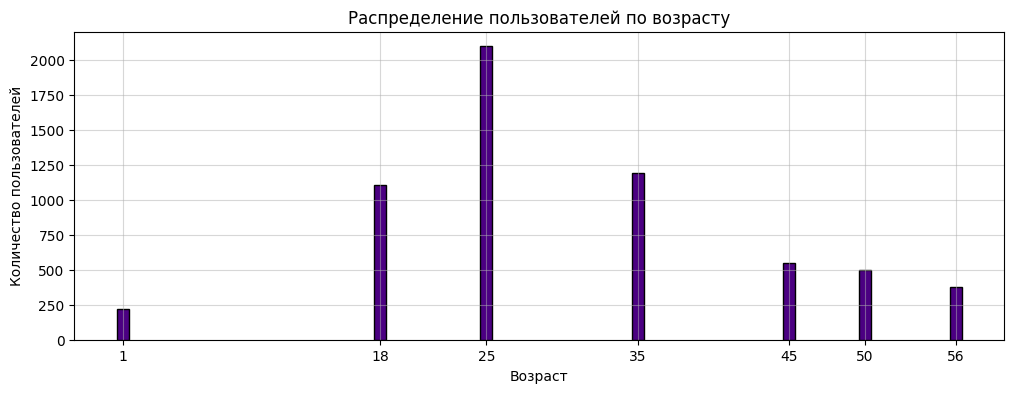

In [12]:
plt.figure(figsize = (12, 4))
age_pop = user_features.age.value_counts()
x = age_pop.index

plt.bar(age_pop.index, age_pop, edgecolor='black', color = 'indigo')  # bins=5 для категорий от 1 до 5
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.xticks(x)
plt.grid(alpha = 0.5)
plt.show()

**Рейтинги фильмов**

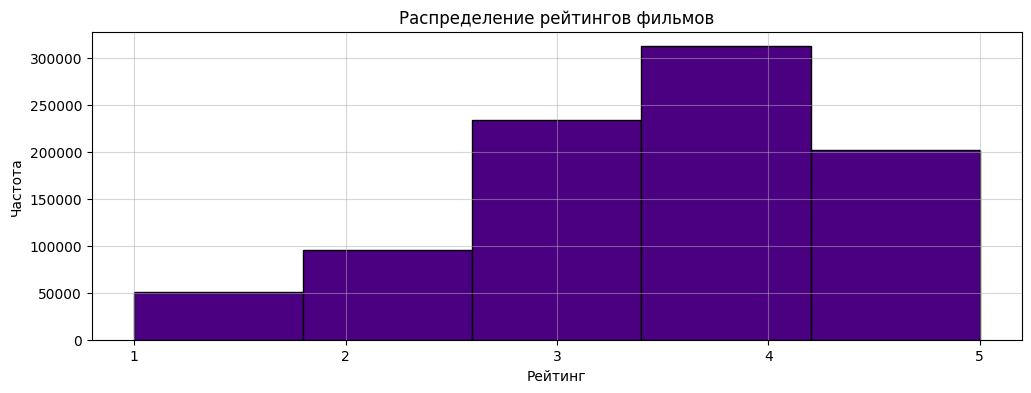

In [13]:
plt.figure(figsize = (12, 4))

plt.hist(events.rating, bins = 5, edgecolor='black', color = 'indigo')  # bins=5 для категорий от 1 до 5
plt.title('Распределение рейтингов фильмов')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.xticks([1, 2, 3, 4, 5])  # Установка меток по оси X для значений рейтинга
plt.grid(alpha = 0.5)  # Сетка для улучшения визуализации
plt.show()

**Жанры фильмов**

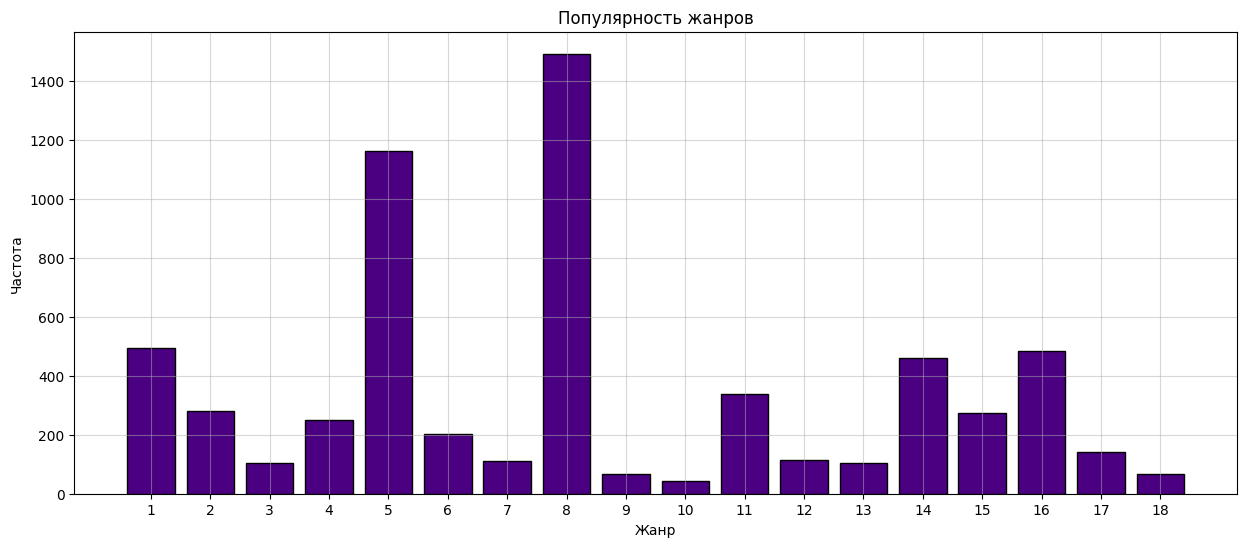

In [14]:
genre_popularity = item_features.drop(['item_id'], axis = 1).sum(axis = 0)
plt.figure(figsize = (15, 6))
x = np.arange(1, genre_popularity.shape[0] + 1)

plt.bar(x, genre_popularity, edgecolor='black', color = 'indigo')  # bins=5 для категорий от 1 до 5
plt.title('Популярность жанров')
plt.xlabel('Жанр')
plt.ylabel('Частота')
plt.xticks(x)  # Установка меток по оси X для значений рейтинга
plt.grid(alpha = 0.5)  # Сетка для улучшения визуализации
plt.show()

In [7]:
# Объединим все датасеты в один
events_with_user_features = events.merge(user_features, on='user_id')
data_merged = events_with_user_features.merge(item_features, on='item_id')
data_merged = data_merged.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

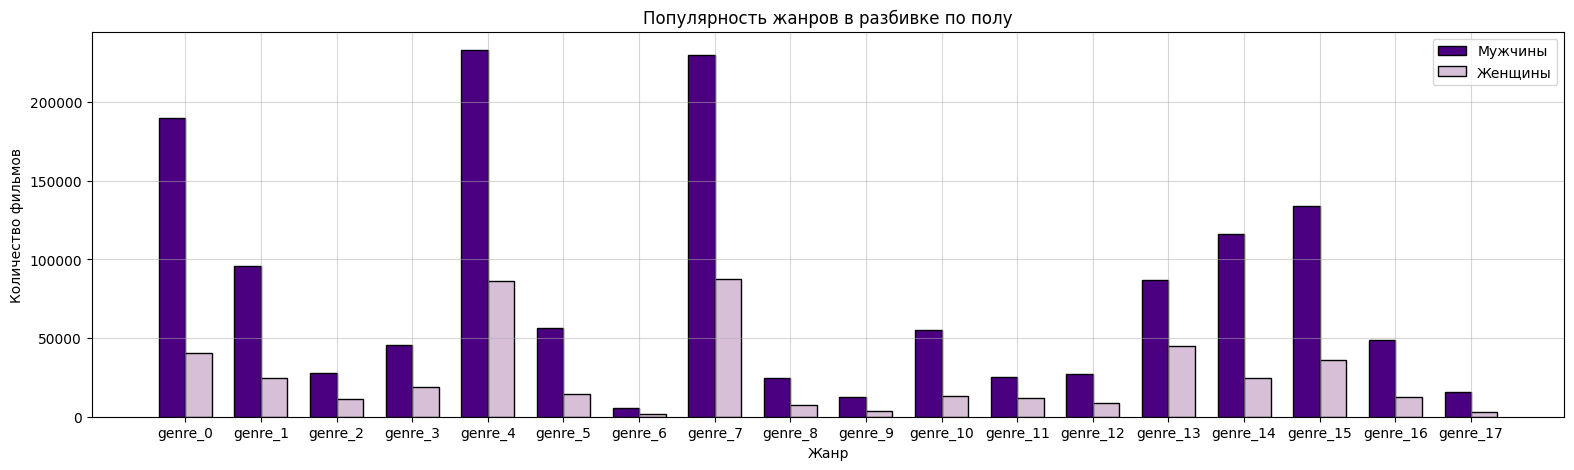

In [8]:
genre_columns = ['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4','genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10',
       'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17']

popularity_male = data_merged[data_merged['gender'] == 'M'][genre_columns].sum()
popularity_female = data_merged[data_merged['gender'] == 'F'][genre_columns].sum()

x = np.arange(1, len(genre_columns) + 1)
width = 0.35

fig, ax = plt.subplots(figsize=(19, 5))

ax.bar(x - width/2, popularity_male, width, label='Мужчины', color='indigo', edgecolor='black')
ax.bar(x + width/2, popularity_female, width, label='Женщины', color='thistle', edgecolor='black')

ax.set_title('Популярность жанров в разбивке по полу')
ax.set_xlabel('Жанр')
ax.set_ylabel('Количество фильмов')
ax.set_xticks(x)
ax.set_xticklabels(genre_columns)

ax.legend()
ax.grid(alpha=0.5)
plt.show()

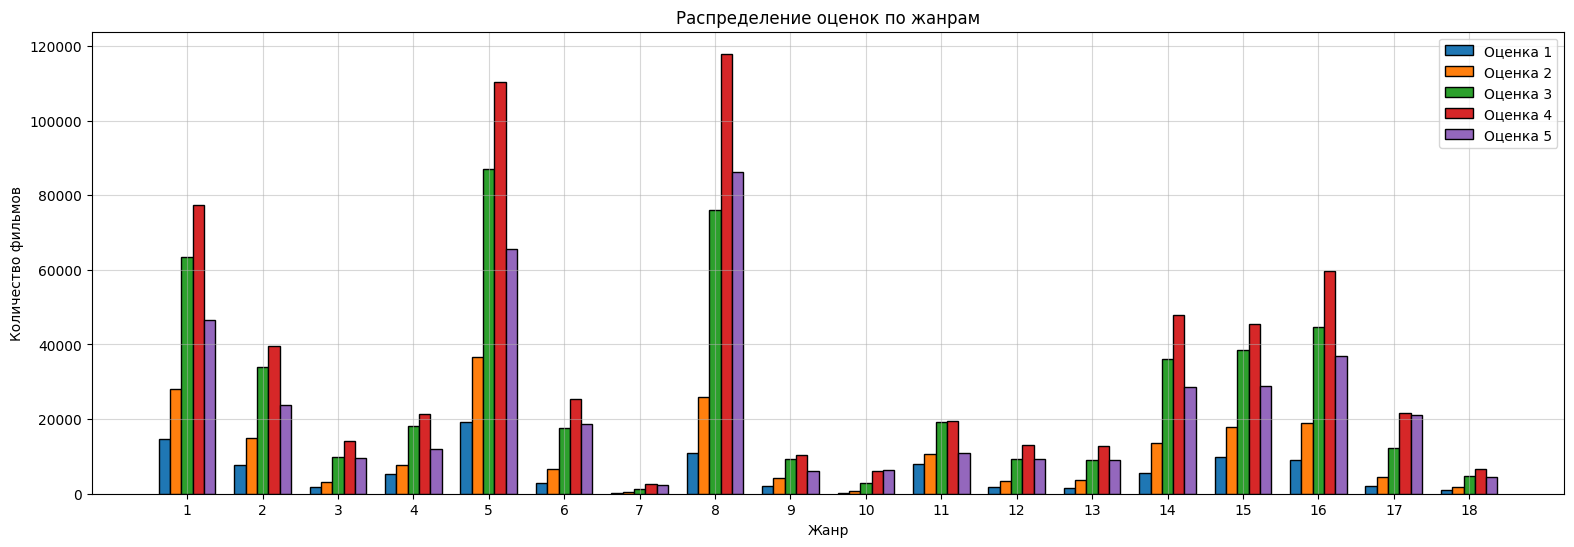

In [8]:
rating_values = [1, 2, 3, 4, 5]

popularity = pd.DataFrame(0, index = genre_columns, columns = rating_values)

for rating in rating_values:
    popularity[rating] = data_merged[data_merged['rating'] == rating][genre_columns].sum()


x = np.arange(1, len(genre_columns) + 1)
width = 0.15

fig, ax = plt.subplots(figsize=(19, 6))

for i, rating in enumerate(rating_values):
    ax.bar(x + i * width, popularity[rating], width, label = f'Оценка {rating}', edgecolor = 'black')

ax.set_title('Распределение оценок по жанрам')
ax.set_xlabel('Жанр')
ax.set_ylabel('Количество фильмов')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(x)


ax.legend()
ax.grid(alpha = 0.5)
plt.show()

## Feature Engineering

Забрать последнее событие с каждого пользователя

In [9]:
test_items = pd.DataFrame(events.groupby('user_id').item_id.last()).reset_index()
test_items.head()

,user_id,item_id
0,0,3360
1,1,584
2,2,2625
3,3,3344
4,4,1868


In [10]:
tmp = pd.merge(events, test_items, on=['user_id','item_id'], how='left', indicator='merged_by')
train_items = tmp[tmp.merged_by == 'left_only'].drop('merged_by', axis=1)
train_items.head()

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1
2,0,584,4,2
3,0,3390,3,3
4,0,2885,4,4


In [11]:
# Тестовая выборка

events_with_user_features = pd.merge(test_items, events, on=['user_id', 'item_id'])
events_with_user_features = events_with_user_features.merge(user_features, on='user_id')
test = events_with_user_features.merge(item_features, on='item_id')

test = test.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

In [12]:
# Тренировочная выборка
events_with_user_features = train_items.merge(user_features, on='user_id')
train = events_with_user_features.merge(item_features, on='item_id')

train = train.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

Будем использовать этот датасет как финальный.

### User-based Features

Список фич по пользователю:


1.   Пол юзера
2.   Возраст юзера
3.   Суммарное количество интеракций (просмотров фильмов)
4.   Средний рейтинг оцениваемых фильмов
5.   Набор жанров последних N просмотренных фильмов
6.   Суммарный набор жанров всех просмотренных фильмов



In [13]:
# Количество просмотров фильмов
count_interactions = train_items.groupby('user_id').item_id.count()
count_interactions.name = 'cnt_interact'

In [14]:
# Средний рейтинг
mean_user_rating = train.groupby('user_id').rating.mean()
mean_user_rating.name = 'avg_user_rat'

In [15]:
# Суммарные просмотры жанра i
user_most_viewed_genres = train.groupby('user_id')[genre_columns].sum()

In [16]:
# Для каждого пользователя найти три самых любимых жанра

def get_top_genres(row, n=3):
    return row.nlargest(n).index.tolist()

top_genres = user_most_viewed_genres.apply(get_top_genres, axis=1)

top_genres.name = 'top_genres'
top_genres = top_genres.to_frame()

top_genres = top_genres.assign(
    **{f'top_genre{i+1}': top_genres['top_genres'].apply(lambda x: x[i]) for i in range(3)}
)

top_genres = top_genres.drop('top_genres', axis=1)

In [17]:
# Окей, три самых любимых жанра - понятно, но что если учесть, что некоторые жанры в целом более популярны
# Относительная любовь к жанру, по отношению к любви к этому жанру других пользователей

most_viewed_genres = train[genre_columns].sum()
rel_user_most_viewed_genres = user_most_viewed_genres/most_viewed_genres

rel_top_genres = rel_user_most_viewed_genres.apply(get_top_genres, axis=1)

rel_top_genres.name = 'rel_top_genres'
rel_top_genres = rel_top_genres.to_frame()

rel_top_genres = rel_top_genres.assign(
    **{f'rel_top_genre{i+1}': rel_top_genres['rel_top_genres'].apply(lambda x: x[i]) for i in range(3)}
)

rel_top_genres = rel_top_genres.drop('rel_top_genres', axis=1)

In [19]:
# Расчет средних значений рейтинга пользователя за последние 5, 10, 50, 100 просмотров

def rolling_mean(df, window_size):
    return df.groupby('user_id')['rating'].apply(
        lambda x: x.rolling(window=window_size, min_periods=0, closed='left').mean()
    )

data_merged['mean_last_5'] = rolling_mean(data_merged, 5).reset_index(level=[0], drop=True).fillna(3.58)
data_merged['mean_last_10'] = rolling_mean(data_merged, 10).reset_index(level=[0], drop=True).fillna(3.58)
data_merged['mean_last_50'] = rolling_mean(data_merged, 50).reset_index(level=[0], drop=True).fillna(3.58)
data_merged['mean_last_100'] = rolling_mean(data_merged, 100).reset_index(level=[0], drop=True).fillna(3.58)

,user_id,item_id,rating,timestamp,gender,age,genre_0,genre_1,genre_2,genre_3,...,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,mean_last_5,mean_last_10,mean_last_50,mean_last_100
0,0,1505,4,0,M,35,1,0,0,0,...,0,0,0,0,0,0,3.580000,3.580000,3.580000,3.580000
1,0,3669,3,1,M,35,0,0,0,0,...,0,1,0,0,0,0,4.000000,4.000000,4.000000,4.000000
2,0,584,4,2,M,35,1,1,0,0,...,0,0,1,0,0,0,3.500000,3.500000,3.500000,3.500000
3,0,3390,3,3,M,35,0,0,0,0,...,0,0,0,0,0,0,3.666667,3.666667,3.666667,3.666667
4,0,2885,4,4,M,35,1,0,0,0,...,0,0,0,0,0,0,3.500000,3.500000,3.500000,3.500000


### Item-Based Features

Список фич по айтемам:


1.   Средний рейтинг среди пользователей
2.   Средний рейтинг фильмов того же жанра



In [18]:
# Средний рейтинг айтема
item_mean_rating = train.groupby('item_id').rating.mean()
item_mean_rating.name = 'avg_item_rat'


In [24]:
# Средний рейтинг жанра
mean_ratings_by_genre = [train[train[f'genre_{i}'] == 1].rating.mean() for i in range(18)]
mean_ratings_by_genre = pd.Series(mean_ratings_by_genre, index=genre_columns)

In [25]:
from tqdm import tqdm
tqdm.pandas()

# Усредненный средний рейтинг фильмов с такими же жанрами (хотя бы одним из)
mean_rating_such_genres = train.progress_apply(lambda x: mean_ratings_by_genre[x[genre_columns] == 1].mean(), axis=1)

100%|█████████████████████████████████| 894149/894149 [01:41<00:00, 8766.50it/s]


## Генерация кандидатов

### User2User

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

data = train[['user_id', 'item_id', 'rating']]


user_item_matrix = data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)


scaler = StandardScaler()
user_item_matrix_scaled = scaler.fit_transform(user_item_matrix)


user_similarity = cosine_similarity(user_item_matrix_scaled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)


def get_user_recommendations(target_user_id, user_item_matrix, user_similarity_df, N=5):
    target_user_ratings = user_item_matrix.loc[target_user_id]
    similar_users = user_similarity_df[target_user_id].sort_values(ascending=False).index[1:500]
    
    weighted_ratings = pd.Series(0, index=user_item_matrix.columns)
    
    for user in similar_users:
        similarity_score = user_similarity_df.loc[target_user_id, user]
        user_ratings = user_item_matrix.loc[user]
        weighted_ratings += user_ratings * similarity_score
    
    weighted_ratings = weighted_ratings[target_user_ratings == 0]
    
    return weighted_ratings.sort_values(ascending=False).head(N)


user_id = 0
recommendations = get_user_recommendations(user_id, user_item_matrix, user_similarity_df, N=10)
print(f"Рекомендации для пользователя {user_id}:\n{recommendations}")


Рекомендации для пользователя 0:
item_id
2732    187.880944
1811    169.928440
2256    162.421250
2630    150.343709
1543    148.468174
331     143.477170
3059    143.240185
2862    142.703195
472     139.936523
790     136.497262
dtype: float64


### ALS Explicit

In [29]:
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares

data = train[['user_id', 'item_id', 'rating']]

user_item_matrix = sparse.csr_matrix((data['rating'], (data['user_id'], data['item_id'])))

model = AlternatingLeastSquares(
    factors=400,
    regularization=0.1,
    iterations=400,
    use_gpu=False
)

model.fit(user_item_matrix)


  0%|          | 0/400 [00:00<?, ?it/s]

### Самые популярные

In [97]:
popular = train.item_id.value_counts().nlargest(10).index

### Самые популярные по полу

In [32]:
popular_gender = train.groupby(['gender', 'item_id']).user_id.count()
popular_gender = popular_gender.groupby('gender').nlargest(10).reset_index(level=[0, 1], drop=True).index

### Самые популярные по возрасту

In [33]:
popular_age = train.groupby(['age', 'item_id']).user_id.count()
popular_age = popular_age.groupby('age').nlargest(5).reset_index(level=[0, 1], drop=True).index

### Наибольший рейтинг

In [34]:
largest_rating = train.groupby('item_id').rating.mean().nlargest(20).index

### Наибольшая популярность + рейтинг

In [35]:
mean_rating = train.groupby('item_id').rating.mean()
log_popularity = np.log(train.groupby('item_id').user_id.count())
pop_rating = (mean_rating*log_popularity).nlargest(20).index

In [98]:
candidates = popular

In [36]:
candidates = list(set(popular) | set(popular_gender) | set(popular_age) | set(largest_rating) | set(pop_rating))
# 30 + 20 + 35 + 20 + 20

### Catboost обучение

In [21]:
negative_samples = pd.DataFrame(np.vstack([
np.random.choice(list(range(len(train['user_id'].unique()))), 2*len(train)),
np.random.choice(list(range(len(train['item_id'].unique()))), 2*len(train))]
), index=['user_id', 'item_id']).T

negative_samples = train_items.merge(negative_samples, on=['user_id', 'item_id'], how='right', indicator='indicator')
negative_samples = negative_samples[negative_samples.indicator == 'right_only'][['user_id', 'item_id']]

In [22]:
positive_sample = train_items.assign(target=1)
negative_sample = negative_samples.assign(target=0)

In [150]:
data = pd.concat([positive_sample, negative_sample])
data = data.drop(['rating', 'timestamp'], axis=1)

In [151]:
def als_score(row):
    return model.user_factors[row['user_id']].dot(model.item_factors[row['item_id']])

In [ ]:
data['als_score'] = data.apply(als_score, axis=1)
test_items['als_score'] = test_items.apply(als_score, axis=1)

In [66]:
def merge_features(data):
    data = data.merge(user_features, on='user_id')
    data = data.merge(item_features, on='item_id')
    data = data.merge(count_interactions, on='user_id')
    data = data.merge(mean_user_rating, on='user_id')
    data = data.merge(top_genres, on='user_id')
    data = data.merge(rel_top_genres, on='user_id')
    #data = pd.merge(
    #    data,
    #    data_merged[['user_id', 'item_id', 'mean_last_5', 'mean_last_10', 'mean_last_50', 'mean_last_100']],
    #    on=['user_id', 'item_id'], how='left'
    #)
    data = data.merge(item_mean_rating, on='item_id')
    
    return data

In [ ]:
data = merge_features(data)
test_data = merge_features(test_items)

In [ ]:
train_target = data['target']
train_data = data.drop(['target', 'user_id', 'item_id'], axis=1)


test_data = test_data.drop(['user_id', 'item_id'], axis=1)

In [ ]:
catboost = CatBoostClassifier(iterations=500)
cat_cols = ['gender', 'top_genre1', 'top_genre2', 'top_genre3', 'rel_top_genre1', 'rel_top_genre2', 'rel_top_genre3']
catboost.fit(train_data, train_target, cat_features = cat_cols, verbose=25)
pred = catboost.predict(test_data)
test_target = np.ones_like(pred)

### Инференс кандидатов

In [20]:
users = pd.DataFrame({'user_id' : range(train_items['user_id'].max() + 1)})

In [21]:
def f(x):
    return model.recommend(x, user_item_matrix[x['user_id']], N=10)[0][0]

als_items = users.apply(f, axis=1)

als_items.name = 'als_items'
als_items = als_items.to_frame()

als_items = als_items.assign(
    **{f'{i+1}': als_items['als_items'].apply(lambda x: x[i]) for i in range(10)}
)

als_items = als_items.drop('als_items', axis=1)
als_items.columns = als_items.columns.astype(int)
als_items = als_items.unstack().reset_index(level = [0, 1]).sort_values(['level_1', 'level_0'])
als_items = als_items.drop('level_0', axis=1)
als_items = als_items.rename(columns={'level_1': 'user_id', 0: 'item_id'})

In [133]:
possible_items = candidates

items = pd.DataFrame({'item_id' : possible_items})

In [144]:
users_items = users.merge(items, how='cross')

In [145]:
users_items = users_items.reset_index(drop=True).drop_duplicates()

In [143]:
# Фильтруем дубликаты
users_items = pd.concat([users_items, als_items]).reset_index(drop=True).drop_duplicates()

In [86]:
users_items = users_items.groupby('user_id').head(10)

In [ ]:
# Фильтруем items, которые пользователь уже смотрел
tmp = pd.merge(users_items, test_items, on=['user_id','item_id'], how='left', indicator='merged_by')
users_items = tmp[tmp.merged_by == 'left_only'][['user_id', 'item_id']]

In [101]:
preds = catboost.predict_proba(users_items.drop(['user_id', 'item_id'], axis=1))

In [103]:
users_items['prob'] = preds[:, 1]

In [41]:
def top_10(x):
    return x.nlargest(10).index.tolist()

In [ ]:
users_items['prob'] = 1
users_items_predict = users_items.set_index(['item_id']).groupby('user_id').prob.apply(top_10)

users_items_predict = users_items_predict.apply(lambda x: ' '.join(list(map(str, x)))).to_frame().reset_index().rename({'prob': 'item_id'}, axis=1)

In [154]:
predict

user_id
0       [1811, 3696, 2256, 331, 1001, 2732, 3435, 1304...
1       [1801, 563, 1699, 584, 1491, 3066, 2222, 2175,...
2       [1956, 2342, 1831, 640, 2338, 2210, 2646, 463,...
3       [2342, 3022, 3327, 3435, 1617, 2194, 2768, 300...
4       [2297, 2210, 3022, 2646, 1583, 1490, 1039, 222...
                              ...                        
6035    [584, 2784, 1927, 1956, 2510, 3529, 463, 1855,...
6036    [3692, 169, 36, 3529, 1560, 1039, 2862, 3013, ...
6037    [3409, 36, 472, 1223, 618, 1315, 463, 1505, 30...
6038    [1583, 640, 1808, 1615, 3489, 1762, 182, 2920,...
6039    [3022, 1831, 640, 2342, 2067, 3053, 2194, 563,...
Name: prob, Length: 6040, dtype: object

In [24]:
als_items_predict.to_csv('predict_als_7.csv', index=False)

## Подсчет Recall@10

In [25]:
def recall_at_10(recommendations, item_id):
    recommended_items = set(recommendations)
    
    recall = int(item_id in recommended_items)
    return recall

In [26]:
def get_predict(file_path):
    predict = pd.read_csv(file_path)
    return predict

In [27]:
num_users = test_items.shape[0]
recalls = []

for user_id in tqdm(range(num_users)):
    predict = get_predict('predict_als_7.csv')
    recommendations = list(map(int, predict.loc[user_id, 'item_id'].split()))
    recall = recall_at_10(recommendations, test_items.loc[user_id, 'item_id'])
    recalls.append(recall)
    
# Усредненный Recall@10 по всем пользователям
mean_recall = np.mean(recalls)
mean_recall

100%|██████████████████████████████████████| 6040/6040 [00:16<00:00, 371.68it/s]


0.08642384105960264

- Item2Item - 0.04718
- ALS - 0.08961
- CatBoost - 0.054786
- Bert - 0.1703

Проработать холодный старт

Сделать умный таргет

Models

Формирование посылки